# Drug-Drug Similarity Based on Molecular Structure


                                                                                by Alberto Olivares Alarcos

This notebook is part of the code developed into a Master Thesis and it is devoted to give a flavour of how to obtain a measurement of similarity between pairs of drugs considering their molecular structure. As said before, this code is part of a Master Thesis, so we are not going to spend too much time explaining theoretical aspects. Please, if you have further interest in the project (e.g. knowing about the decision making), contact the author by e-mail: ***alberto.olivares.alarcos@gmail.com***.

## Background

Measures of structural similarity play an important role in chemoinformatics for applications such as similarity searching, database clustering and molecular diversity analysis. 

The importance of structural similarity derives in large part from the Similar Property Principle, which states that molecules that are structurally similar are likely to have similar properties.

The main three elements of any similarity measure based on Molecular Structure are: 

**Representation or Descriptor.** It is used to characterize the two molecules that are being compared. Among all the possible descriptors we use the fingerprints\footnote{A fingerprint is a vector, each element of which describes the presence of one or more substructures in a molecule, with typical fingerprints containing a few hundred or a few thousand elements, and with two molecules being considered to be similar if their fingerprints share common values for many of the constituent elements.}.

**Weighting Scheme.** It is used to reflect the relative importance of different parts of the representation. No weights are used in this project. 

**Similarity Coefficient.** It is used to quantify the degree of resemblance between two appropriately weighted structural representations. In our case, we use the Tanimoto (Jaccard) Coefficient.


In our approach, we first calculate the fingerprints of each drug, using the information about the Molecular Structure which DrugBank contains. Although molecular description can be obtained in two or three dimensions, we used 2D fingerprints since the number of drugs with 3D information is limited in DrugBank and actually, even thouhg it does make a different, they are not as well established as the fingerprints in the case of 2D representations. 

Using the fingerprints, we compute the similarity among all of them using the Tanimoto Coefficient.  The computation of the Tanimoto Coefficient for two binary vectors ($a$ and $b$) of length $k$ is defined as:

$Tc = \frac{\sum_{j=1}^k a_j \times b_j}{(\sum_{j=1}^k a_j^2 + \sum_{j=1}^k b_j^2 - \sum_{j=1}^k a_j \times b_j)}$

Another important issue to address, is how to actually represent the Molecular Structure of a chemical compound so that a computer can process it efficiently. Normally, the Molecular Structure is represented by well-known methods like: InChi Key or SMILES. However, we cannot use those sorts of representation to compute similarity between drugs. A more efficient representation is provided by fingerprints, a list of binary values (0 or 1) which characterize a molecule. Obviously, the more bits we use, the more precise the representation is. In this project, we have explored two of the most well-known types: MACCS and ECFPs.

##### MACCS
 The MACCS keys are a set of questions about a chemical structure. Here are some of the questions:

    Are there fewer than 3 oxygens?
    Is there a S-S bond?
    Is there a ring of size 4?
    Is at least one F, Cl, Br, or I present?

The result of this is a list of binary values – either true (1) or false (0). This list of values for a given chemical structure is called the MACCS key fingerprint for that structure. 

##### ECFP
Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. They are among the most popular similarity search tools in drug discovery and they are effectively used in a wide variety of applications.


The lenght for the fingerprints we are using in this project are: 167 bits for MACCS and 1024 bits for ECFP. This fact has an effect on the result of the computed similarities. The values of similarities when using MACCS are higher in general. ECFP has more precision (more bits) but that leads us to smaller values of similarity, obviously, the more bits we have, the more difficult is for the pairs of fingerprints to be similar. 

## Evaluation

There are two main sorts of evaluation: direct and indirect. On the one hand, a direct evaluation is the one performed directly over the result you want to study. On the other hand, an indirect evaluation is the one in which you use the obtained result to solve a task and then you evaluate the performance of it over the task. Normally, the ideal evaluation is a direct one, in which the result is compared with a *'golden standard'*. However,it is difficult to evaluate our work since there is not any clear *'golden standard'* to compare our results with. 

In this project, we have performed two different evaluations over the computed similarities:


- **Clustering.** This is an example of indirect evaluation. We have used the similarities to cluster the drugs into groups. Then, we study the ATC Code distribution of those clusters in order to check if our similarity measurements are good. The reason why we use the ATC Code to evaluate is because we have cluster into 14 clusters (the same number of categories of the first level of ATC Code). We did not want to add much theory in this notebook, for that, ask for the Master Thesis documentation to the author. 

- **Ground Truth.** This evaluation is a small direct evaluation we have done with a ground truth annotated by experts in the domain. The similarity of a list of 100 pairs of drugs were annotated by 143 experts. We have taken it from a paper named: *'The use of 2D fingerprint methods to support the assessment of structural similarity in orphan drug legislation'*. Authors provide a file with this information in the webpage of the journey$^{[1]}$. and modified and adapted to our convenience. We compare the similarity computed for us with the similarity following the experts's opinion. 

|1] https://link.springer.com/article/10.1186/1758-2946-6-5

### Needed Material: RDKit

RDKit *(http://www.rdkit.org/)* is an Open source toolkit for cheminformatics and Machine Learning which contains a lot of methods and functionalities to deal with Molecular Structure data from chemical compounds (including similarity measures). It is written in Python (2 and 3) and has been used in several relevant open source projects (ChEMBL Beaker, myChEMBL, etc.).

The easiest and fastest way to use this tool is to install it using Conda. We have tried other sources but we strongly recommend to use the cited one. Within the project, we have included a description of the installation process we have followed to have our system working. We explain there how to install RDKit and prepare your computer to be able to run this notebook using a specific kernel (which has RDKit installed). 

Note that you could run the present notebook as long as the kernel you use has RDKit installed, so feel free to use other methods to install it. 

# IMPLEMENTATION

In [1]:
# Headers
import os
import sys
import scipy
import itertools
import gzip
import pandas
import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem
import rdkit.DataStructs
import time
import copy
import numpy
import matplotlib.pyplot as plt
from IPython.display import Image
import csv
from operator import itemgetter

from sklearn.cluster import SpectralClustering 

HERE = os.path.abspath(os.path.dirname("__file__"))
sys.path.append(os.path.join(HERE, ".."))

from utils.general_utils import *
from utils.molecular_structure_utils import *
from utils.evaluation_utils import *

print("Done")

Done


In [5]:
# Read SDF File and generate a dictionary of Drugbank IDs
file = './../corpus/structures.sdf' # Version 5.0.11
supplier = rdkit.Chem.SDMolSupplier(file)

molecules = [mol for mol in supplier if mol is not None]

ids = []
for mol in molecules:
    ids.append(mol.GetProp('DATABASE_ID'))
ids_dic = dict(enumerate(ids))

len(molecules)

8738

In [3]:
# Dictionary of drugs and their respective atc codes
if not(os.path.exists('./../data/molecular_structure/drug_atc_dict.pkl')):
    zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
    filename = 'drugbank.xml'

    file = read_zip_file(zip_filepath, filename)
    drug_atc_dict = drugbank_id_atc_dictionary(file)

    save_obj(drug_atc_dict, './../data/molecular_structure/', 'drug_atc_dict')
else:
    drug_atc_dict = load_obj('./../data/molecular_structure/', 'drug_atc_dict')

Several drugs within DrugBank does not have ATC Code. Thus, we compute the distribution of the total of ATC Code.

Total ATC:  3876


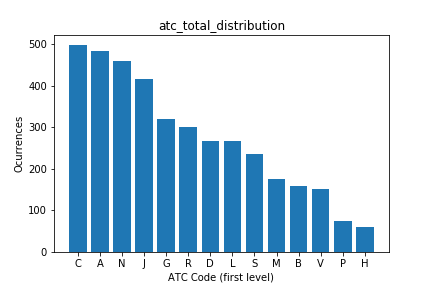

In [4]:
# Distribution of ATC Codes first level of the total set of used drugs with ATC Code in DrugBank
    
all_possible_atc_codes = (list(drug_atc_dict.values()))
    
atc_first_level_all_drugs = list()
for atc_codes in all_possible_atc_codes:
    for atc_code in atc_codes:
        atc_first_level_all_drugs.append(atc_code[0])

print('Total ATC: ', len(atc_first_level_all_drugs))

path_images = './../plots/evaluation/clustering/'

if not (os.path.exists('./../plots/evaluation/clustering/atc_total_distribution.png')):
    save_histogram(atc_first_level_all_drugs, path_images, \
                       'atc_total_distribution')
else: 
    img = Image(filename = path_images + 'atc_total_distribution.png', width=500, height=500)
    display(img)

We count how many drugs of our experiment has ATC Code. The Clustering evaluation could just be done over them.

In [5]:
conti = 0
for db_id in ids:
    atc_codes_dbid = drug_atc_dict[db_id]
    if atc_codes_dbid:
        conti += 1
print(conti) # Drugs from our expriment which actually has a atc code (for the indirect evaluation)

2003


Total ATC:  3512


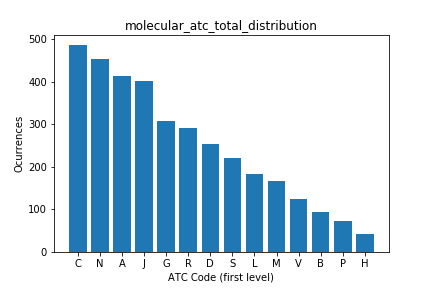

In [6]:
# Distribution of ATC Codes first level of the total set of used drugs
    
atc_first_level_all_drugs = list()
for db_id in ids:
    atc_codes_dbid = drug_atc_dict[db_id]
    for atc_code in atc_codes_dbid:
        atc_first_level_all_drugs.append(atc_code[0])

print('Total ATC: ', len(atc_first_level_all_drugs))

path_images = './../plots/evaluation/clustering/molecular_structure/'

if not (os.path.exists('./../plots/evaluation/clustering/molecular_structure/molecular_atc_total_distribution.png')):
    save_histogram(atc_first_level_all_drugs, path_images, \
                       'molecular_atc_total_distribution')
else: 
    img = Image(filename = path_images + 'molecular_atc_total_distribution.png', width=500, height=500)
    display(img)
    

## AUTOMATIC GENERATION OF FINGERPRINTS

In [7]:
start = time.time()
# Calculate fingerprints
fingerprintsECFP = dict()
fingerprintsMACCS = dict()
for mol in molecules:
    drugbank_id = mol.GetProp('DATABASE_ID')
    fingerprintECFP = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
    fingerprintsECFP[drugbank_id] = fingerprintECFP

    fingerprintMACCS = rdkit.Chem.AllChem.GetMACCSKeysFingerprint(mol)
    fingerprintsMACCS[drugbank_id] = fingerprintMACCS

end = time.time()
print("Execution Time (s): " + str(end - start))   

Execution Time (s): 25.077379941940308


In [8]:
print("Length (bits) of one MACCS fingerprint: ",list(fingerprintsMACCS.values())[1].GetNumBits())

print("Length (bits) of one ECFP fingerprint: ",list(fingerprintsECFP.values())[1].GetNumBits())

Length (bits) of one MACCS fingerprint:  167
Length (bits) of one ECFP fingerprint:  1024


## SIMILARITY MATRICES COMPUTATION

Note that the next module can take a lot of time. Actually, the jupyter kernel could die when trying to compute all the simiarity matrices at the same time so it might be a good strategy to compute them independently. Once the files are generated, we can just open them, however, the first time you download the repository, it is necessary to compute them (every file is around 600MB).

In [2]:
start = time.time()

if not(os.path.exists('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy')):
    tanimoto_similarity_matrix_ECFP = similarity_matrix_molecular_structure(fingerprintsECFP, "tanimoto")
    numpy.save('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy',tanimoto_similarity_matrix_ECFP)
else: 
    tanimoto_similarity_matrix_ECFP = numpy.load('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy')
    
if not(os.path.exists('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy')):
    tanimoto_similarity_matrix_MACCS = similarity_matrix_molecular_structure(fingerprintsMACCS, "tanimoto")
    numpy.save('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy',tanimoto_similarity_matrix_MACCS)
else: 
    tanimoto_similarity_matrix_MACCS = numpy.load('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy')
    
    
if not(os.path.exists('./../data/molecular_structure/dice_sim_matrix_ECFP.npy')):
    dice_similarity_matrix_ECFP = similarity_matrix_molecular_structure(fingerprintsECFP, "dice")
    numpy.save('./../data/molecular_structure/dice_sim_matrix_ECFP.npy',dice_similarity_matrix_ECFP)
else: 
    dice_similarity_matrix_ECFP = numpy.load('./../data/molecular_structure/dice_sim_matrix_ECFP.npy')
    
if not(os.path.exists('./../data/molecular_structure/dice_sim_matrix_MACCS.npy')):
    dice_similarity_matrix_MACCS = similarity_matrix_molecular_structure(fingerprintsMACCS, "dice")
    numpy.save('./../data/molecular_structure/dice_sim_matrix_MACCS.npy',dice_similarity_matrix_MACCS)
else: 
    dice_similarity_matrix_MACCS = numpy.load('./../data/molecular_structure/dice_sim_matrix_MACCS.npy')
    

end = time.time()
print("Execution Time (s): " + str(end - start))  

Execution Time (s): 2.0225415229797363


In [2]:
start = time.time()

if not(os.path.exists('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy')):
    tanimoto_similarity_matrix_ECFP = similarity_matrix_molecular_structure(fingerprintsECFP, "tanimoto")
    numpy.save('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy',tanimoto_similarity_matrix_ECFP)
else: 
    tanimoto_similarity_matrix_ECFP = numpy.load('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy')
    
if not(os.path.exists('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy')):
    tanimoto_similarity_matrix_MACCS = similarity_matrix_molecular_structure(fingerprintsMACCS, "tanimoto")
    numpy.save('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy',tanimoto_similarity_matrix_MACCS)
else: 
    tanimoto_similarity_matrix_MACCS = numpy.load('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy')
    

end = time.time()
print("Execution Time (s): " + str(end - start))  

Execution Time (s): 1.075767993927002


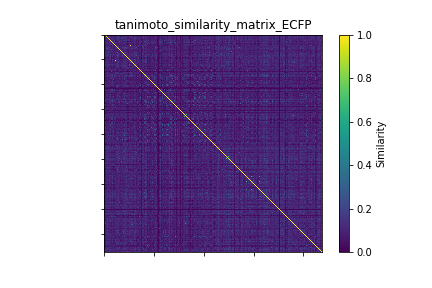

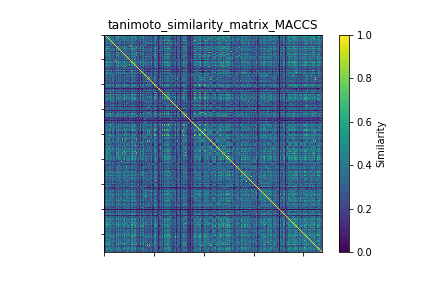

In [3]:
# Visual evaluation of Similarity
path_images = './../plots/molecular_structure/'

if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_ECFP.png')):
    save_similarity_matrix(numpy.array(tanimoto_similarity_matrix_ECFP), path_images, \
                       'tanimoto_similarity_matrix_ECFP')
else: 
    img = Image(filename = path_images + "tanimoto_similarity_matrix_ECFP.png", width=500, height=500)
    display(img)
    
if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_MACCS.png')):
    save_similarity_matrix(numpy.array(tanimoto_similarity_matrix_MACCS), path_images, \
                       'tanimoto_similarity_matrix_MACCS')
else:
    img = Image(filename = path_images + "tanimoto_similarity_matrix_MACCS.png", width=500, height=500)
    display(img)

Study of the correlation between Dice and Tanimoto Coefficients. We also study the correlation between MACCS and ECFP for the case in which we use Tanimoto.

In [10]:
# Checking if there is correlation between Dice and Tanimoto coefficients
n = numpy.shape(dice_similarity_matrix_MACCS)[1]
x = numpy.reshape(dice_similarity_matrix_MACCS, n*n)
y = numpy.reshape(tanimoto_similarity_matrix_MACCS, n*n)
c1 = scipy.stats.pearsonr(x, y)
print("Pearson Correlation Coefficient between Dice and Tanimoto for MACCS: ", c1[0]) 

n = numpy.shape(dice_similarity_matrix_ECFP)[1]
x = numpy.reshape(dice_similarity_matrix_ECFP, n*n)
y = numpy.reshape(tanimoto_similarity_matrix_ECFP, n*n)
c2 = scipy.stats.pearsonr(x, y)
print("Pearson Correlation Coefficient between Dice and Tanimoto for ECFP: ", c2[0]) 

n = numpy.shape(tanimoto_similarity_matrix_ECFP)[1]
x = numpy.reshape(tanimoto_similarity_matrix_ECFP, n*n)
y = numpy.reshape(tanimoto_similarity_matrix_MACCS, n*n)
c3 = scipy.stats.pearsonr(x, y)
print("Pearson Correlation Coefficient between MACCS and ECFP for tanimoto: ", c3[0]) 

Pearson Correlation Coefficient between Dice and Tanimoto for MACCS:  0.9896782493032734
Pearson Correlation Coefficient between Dice and Tanimoto for ECFP:  0.9908445386353344
Pearson Correlation Coefficient between MACCS and ECFP for tanimoto:  0.6009708841666144


## EVALUATION

### EVALUATION: CLUSTERING

In [12]:
# Definition of variables
nclust= 14

save_histograms = False
display_plots = True

In [3]:
# Spectral Clustering
sca_ECFP = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_ECFP.fit(tanimoto_similarity_matrix_ECFP)

sca_MACCS = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_MACCS.fit(tanimoto_similarity_matrix_MACCS)

/home/albertolivares/miniconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=14, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [6]:
# Extract the clusters for ECFP
clusters_idx_ECFP = label_idx(sca_ECFP.labels_, nclust)

clusters_dbid_ECFP = dict()
for l in clusters_idx_ECFP.keys():
     clusters_dbid_ECFP[l] = idx_to_id(clusters_idx_ECFP[l], ids_dic)

In [7]:
# Extract the clusters for MACCS
clusters_idx_MACCS = label_idx(sca_MACCS.labels_, nclust)

clusters_dbid_MACCS = dict()
for l in clusters_idx_MACCS.keys():
     clusters_dbid_MACCS[l] = idx_to_id(clusters_idx_MACCS[l], ids_dic)

In [8]:
# Dictionary of drugs and their respective atc codes
if not(os.path.exists('./../data/molecular_structure/drug_atc_dict.pkl')):
    zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
    filename = 'drugbank.xml'

    file = read_zip_file(zip_filepath, filename)
    drug_atc_dict = drugbank_id_atc_dictionary(file)

    save_obj(drug_atc_dict, './../data/molecular_structure/', 'drug_atc_dict')
else:
    drug_atc_dict = load_obj('./../data/molecular_structure/', 'drug_atc_dict')

In [9]:
# Total of drugs within Drugbank
print(len(drug_atc_dict))

10562


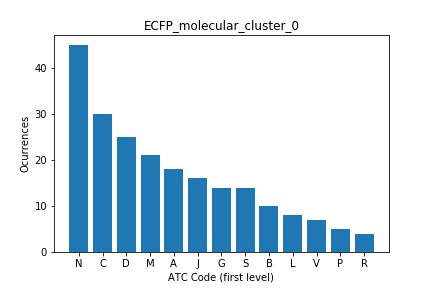

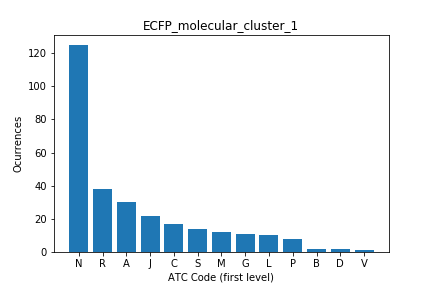

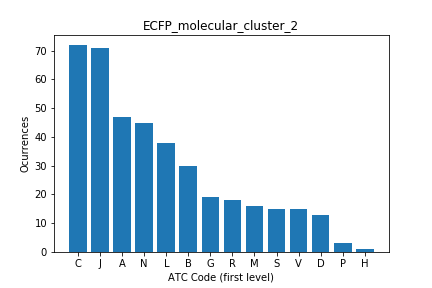

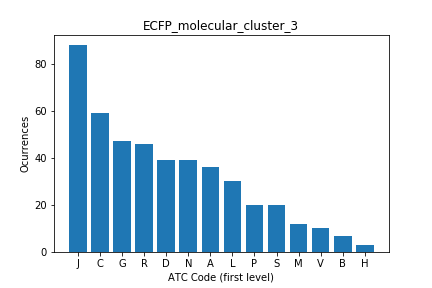

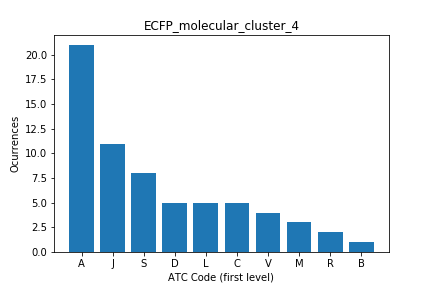

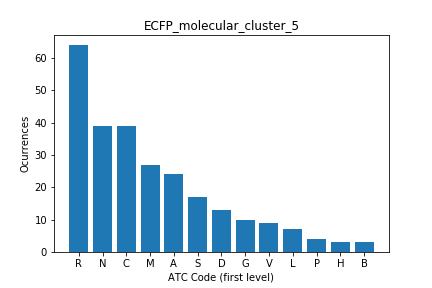

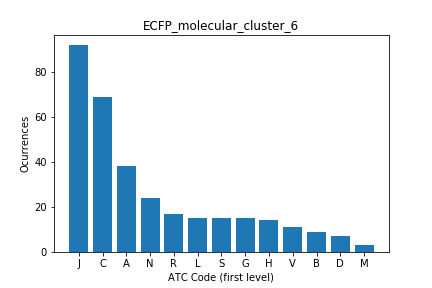

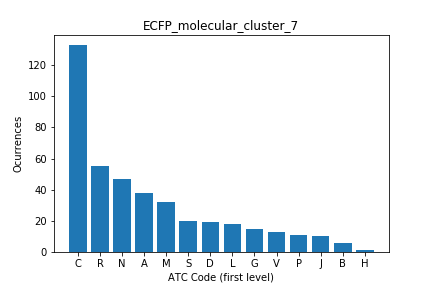

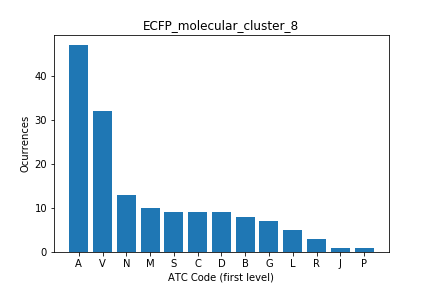

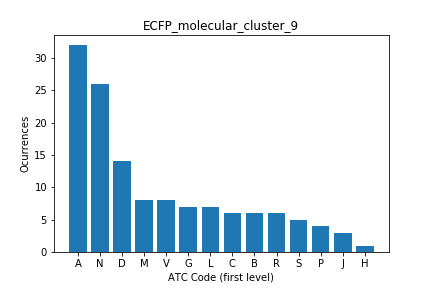

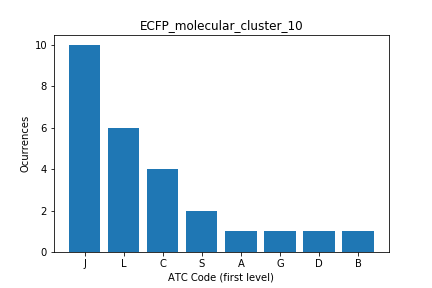

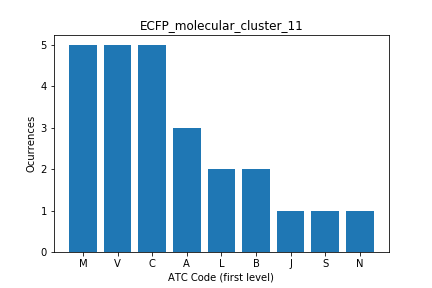

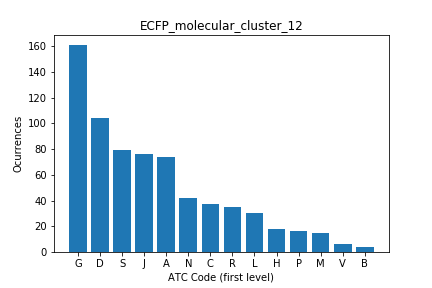

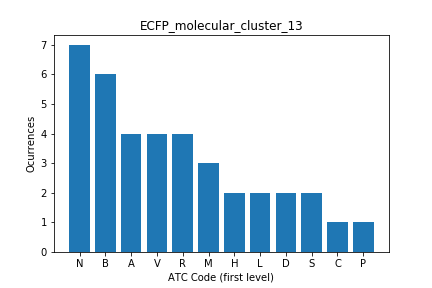

In [13]:
# Clusters ATC code distribution for ECFP
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_ECFP.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = drug_atc_dict[db_id]
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/molecular_structure/'

for i in range (0, len(clusters_ATC_distribution)):
    if not(os.path.exists('./../plots/evaluation/clustering/molecular_structure/ECFP_molecular_cluster_'+str(i)+'.png'))\
    or save_histograms:
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'ECFP_molecular_cluster_'+str(i))
    else: 
        if display_plots:
            img = Image(filename = path_images + 'ECFP_molecular_cluster_'+str(i)+'.png', width=500, height=500)
            display(img)

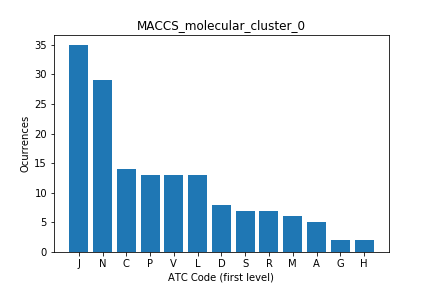

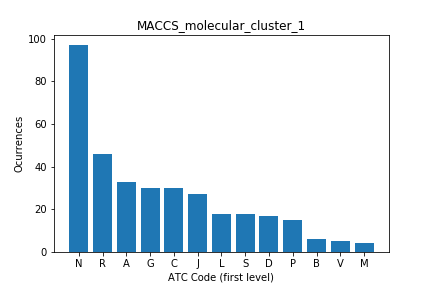

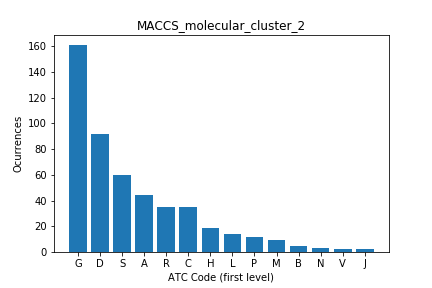

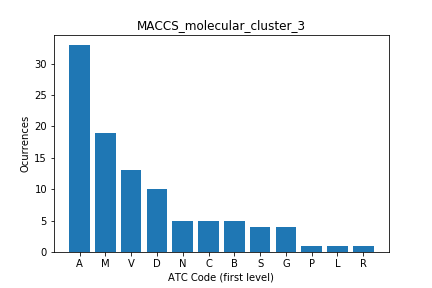

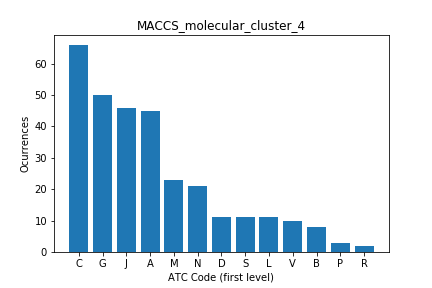

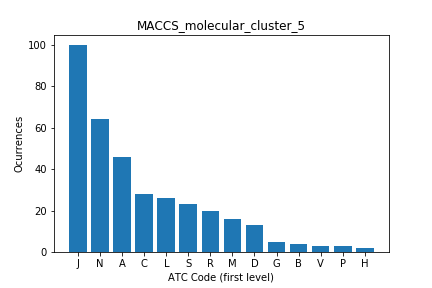

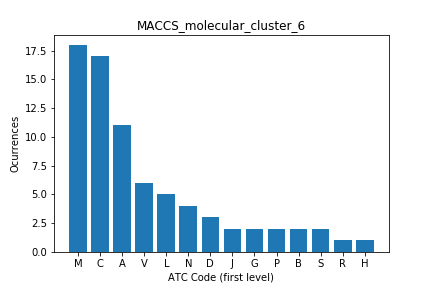

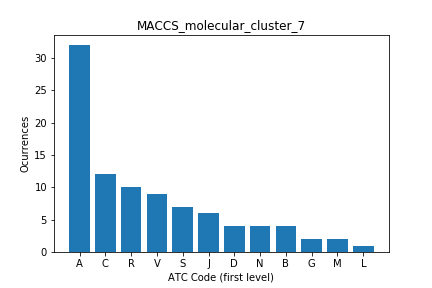

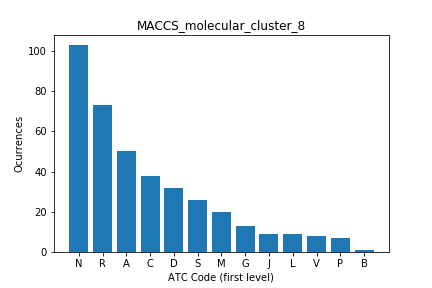

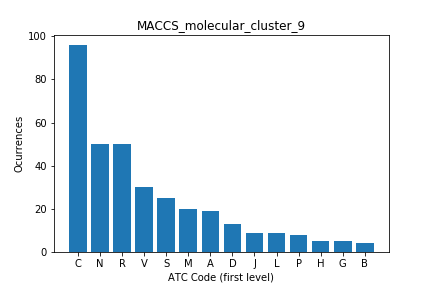

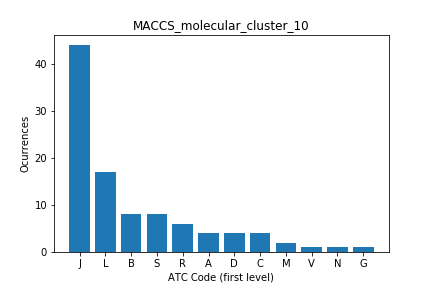

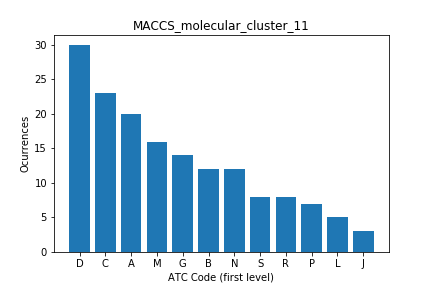

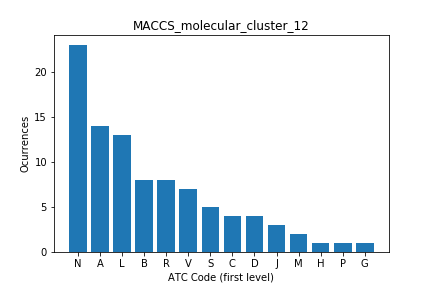

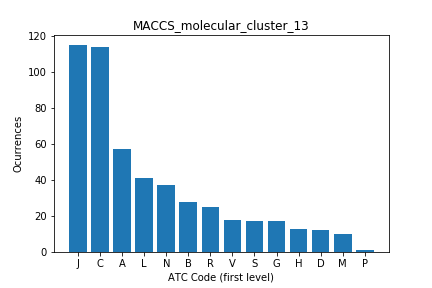

In [14]:
# Clusters ATC code distribution for MACCS
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_MACCS.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = drug_atc_dict[db_id]
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/molecular_structure/'

for i in range (0, len(clusters_ATC_distribution)):
    if not(os.path.exists('./../plots/evaluation/clustering/molecular_structure/MACCS_molecular_cluster_'+str(i)+'.png'))\
    or save_histograms:
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'MACCS_molecular_cluster_'+str(i))
    else: 
        if display_plots:
            img = Image(filename = path_images + 'MACCS_molecular_cluster_'+str(i)+'.png', width=500, height=500)
            display(img)

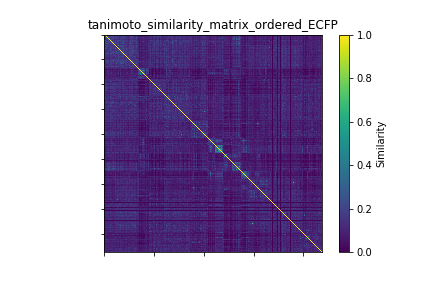

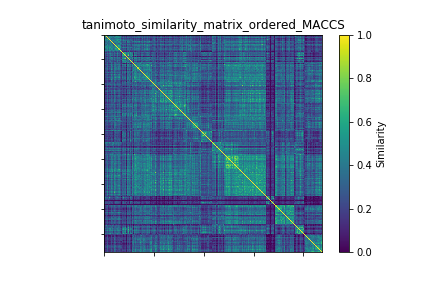

In [15]:
# Order the similarity matrices according to clusters
path_images = './../plots/molecular_structure/'

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_ECFP[i]
    
if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_ordered_ECFP.png')):
    save_similarity_matrix_ordered(numpy.array(tanimoto_similarity_matrix_ECFP), clusters_idx_ordered, \
                                   path_images, 'tanimoto_similarity_matrix_ordered_ECFP')
else: 
    img = Image(filename = path_images + "tanimoto_similarity_matrix_ordered_ECFP.png", width=500, height=500)
    display(img)

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_MACCS[i]
if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_ordered_MACCS.png')):
    save_similarity_matrix_ordered(numpy.array(tanimoto_similarity_matrix_MACCS), clusters_idx_ordered, \
                                   path_images, 'tanimoto_similarity_matrix_ordered_MACCS')
else:
    img = Image(filename = path_images + "tanimoto_similarity_matrix_ordered_MACCS.png", width=500, height=500)
    display(img)

### EVALUATION: GROUND TRUTH

In [16]:
# Extract similarity for a list of pairs from a Similarity Matrix
ground_truth_path = '../data/evaluation/ground_truth.csv'
with open(ground_truth_path, 'rt') as csvfile:
    reader = csv.reader(csvfile)
    ground_truth_list = list(reader)
    
# We add an id for each pair (in order to evaluate afterwards the order infered by the similarity values)
for i in range(0, len(ground_truth_list)):
    ground_truth_list[i].append(i)

computed_ECFP_similarity_list = compute_similarity_between_pairs(ids, tanimoto_similarity_matrix_ECFP, ground_truth_list)
computed_MACCS_similarity_list = compute_similarity_between_pairs(ids, tanimoto_similarity_matrix_MACCS, ground_truth_list)

In [17]:
# Count number of pairs which actually are within our matrix
n = len(computed_ECFP_similarity_list)
counter = 0
for i in range(0, n):
    if computed_ECFP_similarity_list[i][2] == -1:
        counter += 1

In [18]:
print("The total of pairs from the ground truth is: ", n)
print("The number of pairs we have from the total is: ", n - counter) # number of drugs which actually are in our matrix of similarity..

The total of pairs from the ground truth is:  97
The number of pairs we have from the total is:  96


In [19]:
# Here we evaluate two different things, if the order infered by the similarity values is the same in the pairs
# and the correlation among the values of similarities predicted.


# Necessary to not contemplate pairs which are not among our computed similarities (for the order correlation)
computed_ECFP_similarity_list_match = list()
computed_MACCS_similarity_list_match = list()
ground_truth_list_match = list()
for i in range(0, len(computed_ECFP_similarity_list)):
    if not computed_ECFP_similarity_list[i][2] == -1:
        computed_ECFP_similarity_list_match.append(computed_ECFP_similarity_list[i])
        computed_MACCS_similarity_list_match.append(computed_MACCS_similarity_list[i])
        ground_truth_list_match.append(ground_truth_list[i])

ground_truth_list_ordered = sorted(ground_truth_list_match, key=itemgetter(2)) # From 0 to 1 (similarity)
computed_ECFP_similarity_list_ordered = sorted(computed_ECFP_similarity_list_match, key=itemgetter(2))
computed_MACCS_similarity_list_ordered = sorted(computed_MACCS_similarity_list_match, key=itemgetter(2))

print("Correlation (ECFP)")
corr_order = ground_truth_evaluation_order(computed_ECFP_similarity_list_ordered, ground_truth_list_ordered)
print("Order", corr_order)
corr_value = ground_truth_evaluation_value(computed_ECFP_similarity_list, ground_truth_list)
print("Value", corr_value)
acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_ECFP_similarity_list, ground_truth_list, 0.85)
print("Accuracy, Recall: ",acc_threshold, recall_threshold)

print("\nCorrelation (MACCS)")
corr_order = ground_truth_evaluation_order(computed_MACCS_similarity_list_ordered, ground_truth_list_ordered)
print("Order", corr_order)
corr_value = ground_truth_evaluation_value(computed_MACCS_similarity_list, ground_truth_list)
print("Value", corr_value)
acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_MACCS_similarity_list, ground_truth_list, 0.85)
print("Accuracy, Recall: ",acc_threshold, recall_threshold)

Correlation (ECFP)
Order KendalltauResult(correlation=-0.04035087719298245, pvalue=0.5602953155432291)
Value (0.8885935873368818, 1.404783714471167e-33)
Accuracy, Recall:  0.7708333333333334 0.12

Correlation (MACCS)
Order KendalltauResult(correlation=0.0600877192982456, pvalue=0.3857919467847982)
Value (0.9186495912074873, 1.0912957645863173e-39)
Accuracy, Recall:  0.8854166666666666 0.76
